In [21]:
import micom
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
import micom.measures
import numpy as np 
from plotnine import *
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats

%matplotlib inline

# SCFA Prediction
This notebook simulates the growth of MCMMs and validates the predicted probiotic growth rates

## Collect Metadata

In [4]:
# Load the Metadata Tabe
metadata = pd.read_table('../data/studyA_metadata.tsv')

# Drop QC samples
metadata = metadata.drop(metadata.index[[0,83,84]]).rename(columns = {'Name':'sample_id'})

# Create dicts for relevant metadata
subject_dict = metadata.set_index('sample_id')['subject_id'].to_dict()
treatment_dict = metadata.set_index('sample_id')['treatment_group'].to_dict()
metadata

,sample_id,subject_id,time_point,treatment_group
1,C0223873,SS_65,00_Baseline,wbf11
2,C0253061,SS_60,00_Baseline,wbf11
3,C0227725,SS_46,00_Baseline,wbf11
4,C0264833,SS_31,12_Week,placebo
5,C0252289,SS_67,00_Baseline,wbf11
...,...,...,...,...
78,C0228492,SS_118,12_Week,placebo
79,C1064093,SS_102,12_Week,wbf11
80,C0231040,SS_76,12_Week,placebo
81,C0263808,SS_71,12_Week,placebo


## Prepare MCMM Medium
Load standard european medium as assumed background diet

In [5]:
# Load Medium 
eu_medium = pd.read_csv('../european_medium.csv')

# Add inulin supplement, as in trial
eu_medium_wbf11 = pd.concat([eu_medium, pd.DataFrame({'metabolite':['inulin'],
                  'flux':[.061448], 
                  'name':'inulin',
                  'reaction':'EX_inulin_m',
                  'global_id':'EX_inulin(e)'}, index = ['EX_inulin_m'])])

eu_medium_wbf11_30g = pd.concat([eu_medium, pd.DataFrame({'metabolite':['inulin'],
                  'flux':[6.1448], 
                  'name':'inulin',
                  'reaction':'EX_inulin_m',
                  'global_id':'EX_inulin(e)'}, index = ['EX_inulin_m'])])

## Grow Models
All iterations, including placebo group, treatment group with and without inulin & probiotic cocktail

In [6]:
# Probiotic-treated Models
manifest_probiotic = pd.read_csv('../WBF011_treated/manifest.csv')

growth_probiotic= micom.workflows.grow(manifest_probiotic, 
                              model_folder = '../WBF011_treated/',
                              medium = eu_medium_wbf11,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

# Probiotic-treated Models + 30g inulin
growth_probiotic_30g= micom.workflows.grow(manifest_probiotic, 
                              model_folder = '../WBF011_treated/',
                              medium = eu_medium_wbf11_30g,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

# Non-treated Models
manifest_noTreatment = pd.read_csv('../WBF011_noProbiotic/manifest.csv')

growth_noTreatment = micom.workflows.grow(manifest_noTreatment, 
                              model_folder = '../WBF011_noProbiotic/',
                              medium = eu_medium,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

 
# Placebo Models
manifest_placebo = pd.read_csv('../Placebo/manifest.csv')

growth_placebo = micom.workflows.grow(manifest_placebo, 
                              model_folder = '../Placebo/',
                              medium = eu_medium,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)


Running ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━  90% 0:00:07

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Calculate SCFAs
Calculate overall SCFA production from each growth simulation. 

In [13]:
# Calculate Production Rates and Annotate Treatments
production_noTreatment= micom.measures.production_rates(growth_noTreatment)
production_noTreatment['treatment'] = 'No Treatment'
production_probiotic = micom.measures.production_rates(growth_probiotic)
production_probiotic['treatment'] = 'WBF-011 + Inulin, 0.3g'
production_probiotic_30g= micom.measures.production_rates(growth_probiotic_30g)
production_probiotic_30g['treatment'] = 'WBF-011 + Inulin, 30g'

# Concatenate into DF
production = pd.concat([production_noTreatment,production_probiotic,production_probiotic_30g], axis = 0)

# Map Subject IDs 
production['subject_id'] = production['sample_id'].map(subject_dict).str.split('_').str[1] 

# Isolate Butyrate and Propionate
production_but = production[production['metabolite'] == 'but[e]'] 
production_ppa = production[production['metabolite'] == 'ppa[e]']

/users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/measures.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/measures.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/measures.py:35: FutureWarning: DataFrameGroupBy.apply operated on the gr

## Plot Predicted Butyrate Production
Display violin plots for butyrate production for each condition

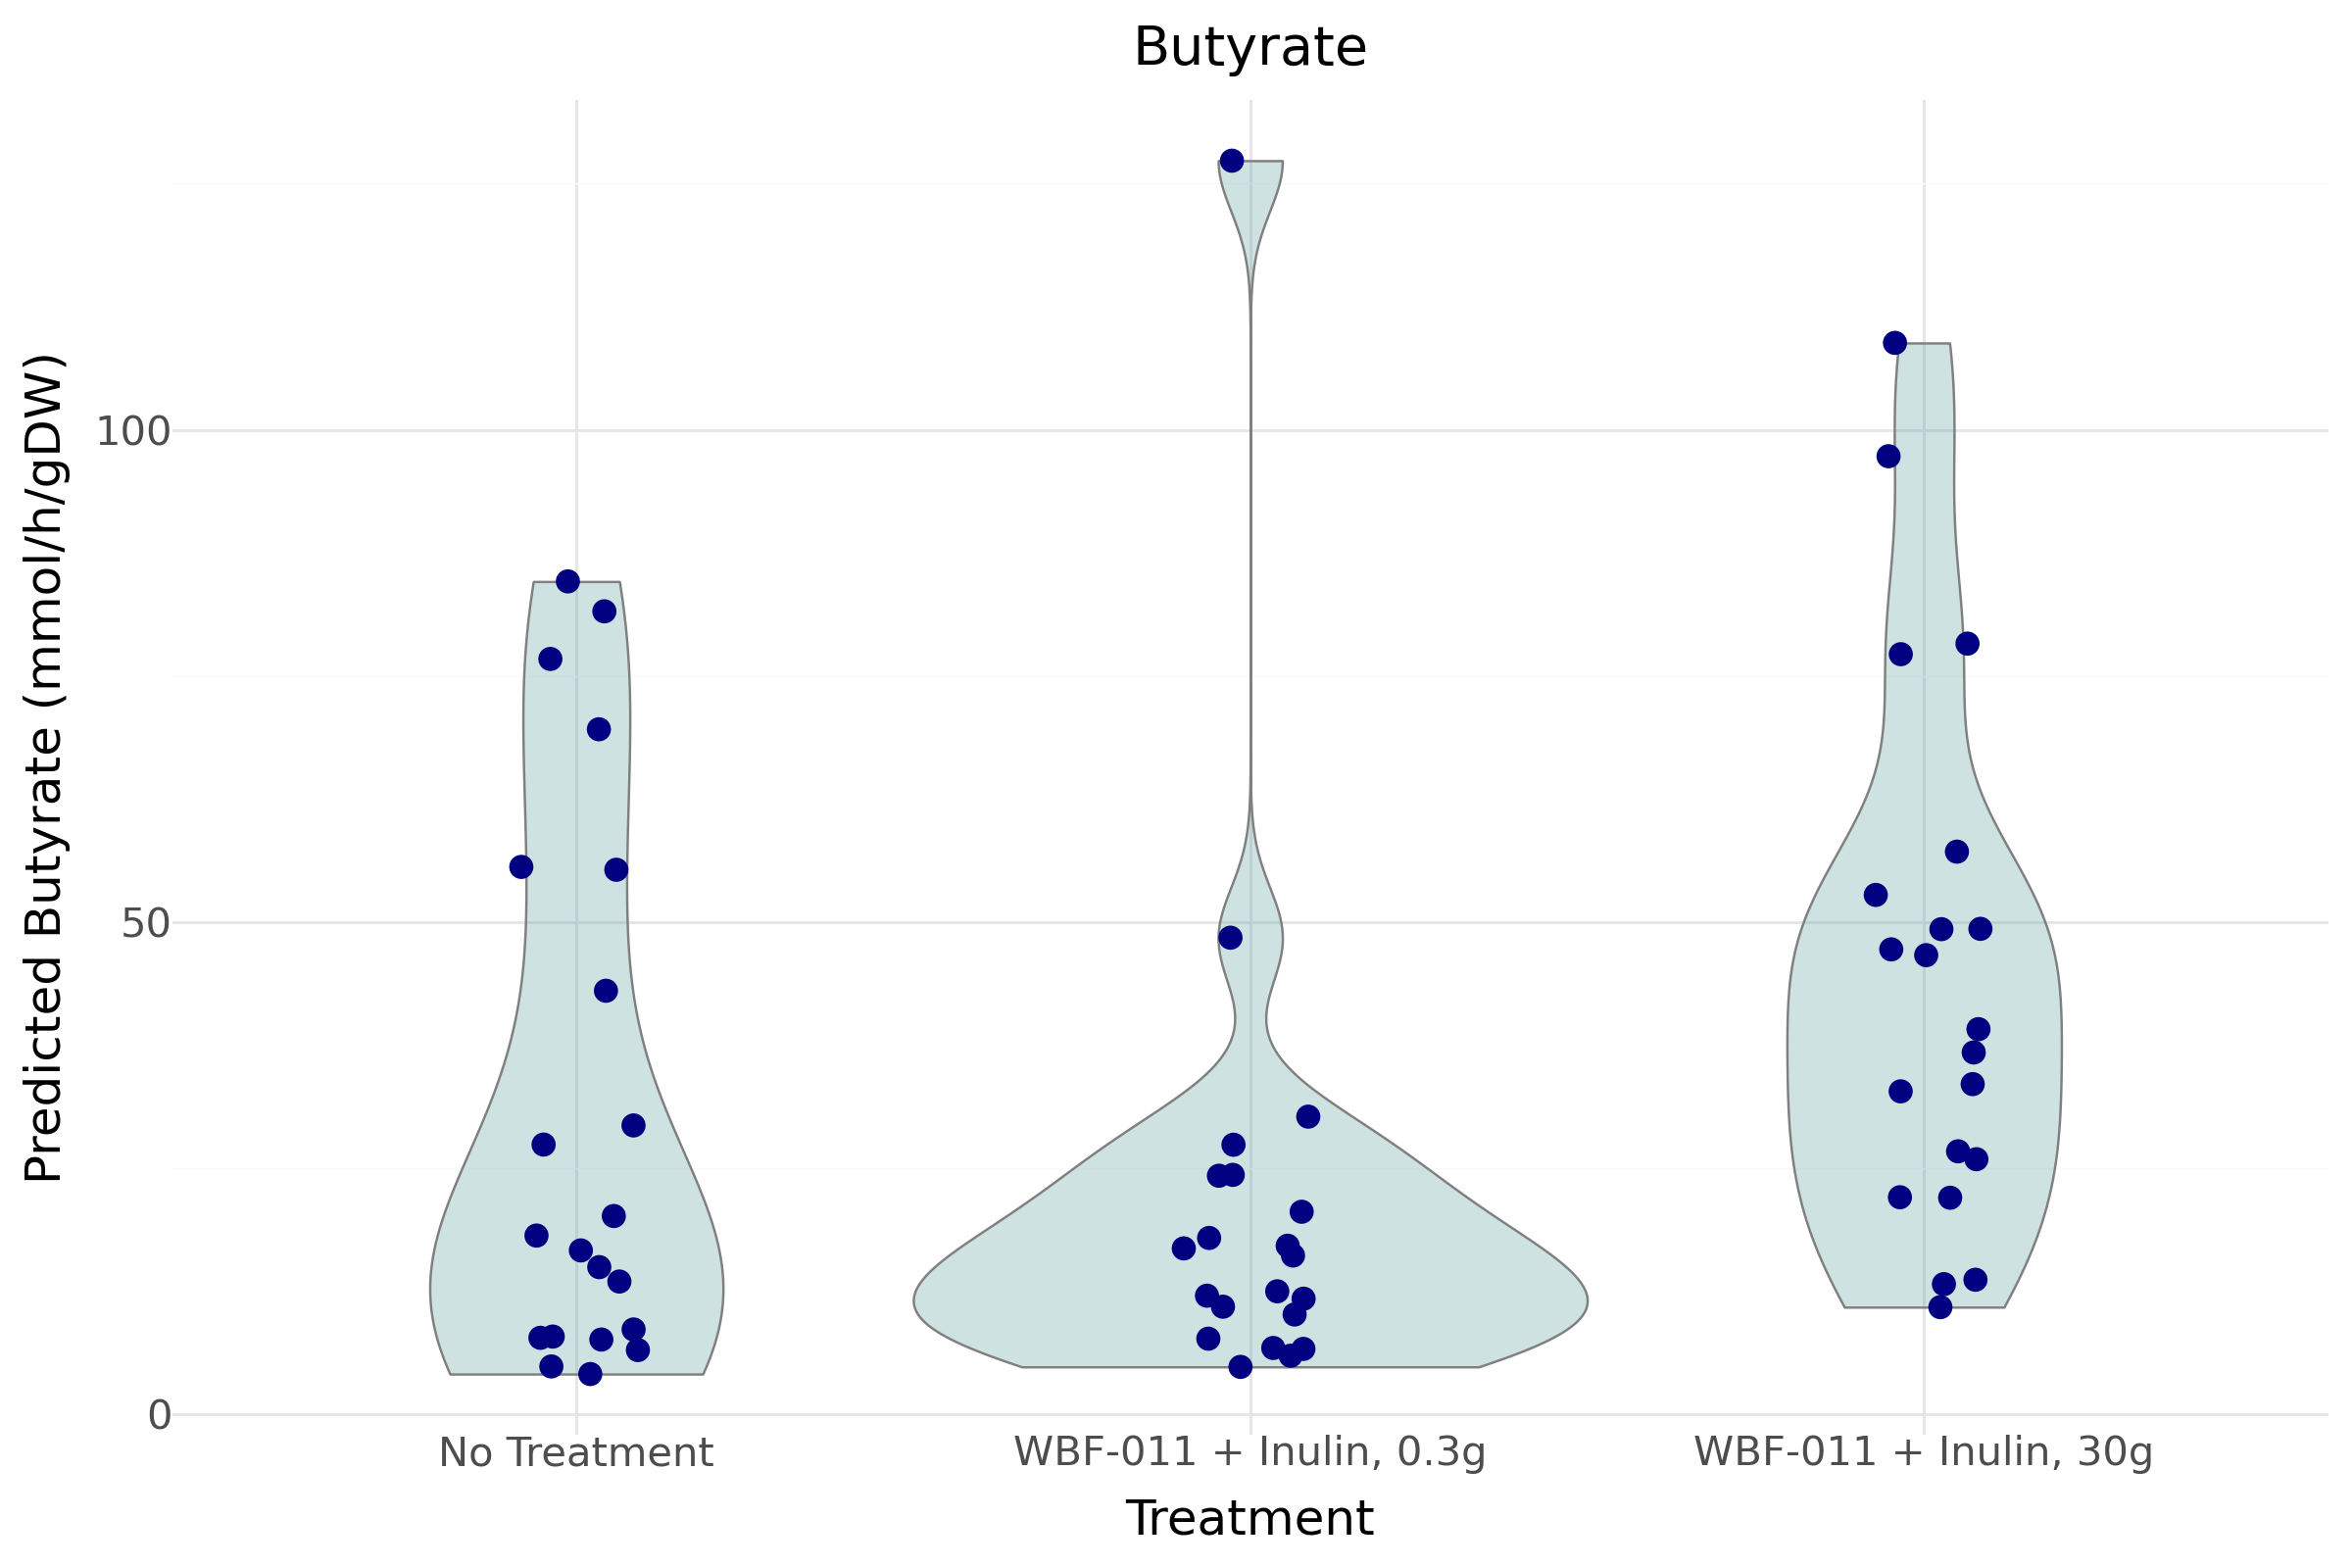

In [14]:
but_plot = (ggplot(production_but, aes(x = 'treatment', y = 'flux'))
            +geom_violin(color = 'gray', fill = 'cadetblue', alpha = 0.3, width = 1)
            +geom_jitter(color = 'navy', width = .1, size = 4)
            +labs(x = 'Treatment', y = 'Predicted Butyrate (mmol/h/gDW)',  title = 'Butyrate')
            +scale_x_discrete(limits = ['No Treatment','WBF-011 + Inulin, 0.3g','WBF-011 + Inulin, 30g'])
            # +ylim(0, 70)
            +theme_minimal()
            +theme(figure_size=(12, 8),  axis_title=element_text(size=18),
        axis_text=element_text(size=15),
        plot_title=element_text(size=20))
            
           )
# ggsave(but_plot, '../figures/butyratePrediction.svg',dpi =200)
but_plot

## Test Significance
Use non-parametric Mann-Whitney to determine signficance in difference of butyrate production between conditions

In [9]:
scipy.stats.mannwhitneyu(production_but[production_but['treatment'] == 'WBF-011 + Inulin, 0.3g']['flux'],
                         production_but[production_but['treatment'] == 'No Treatment']['flux'])

MannwhitneyuResult(statistic=np.float64(185.0), pvalue=np.float64(0.37861508946133926))

## Plot Predicted Propionate Production
Display violin plots for propionate production for each condition

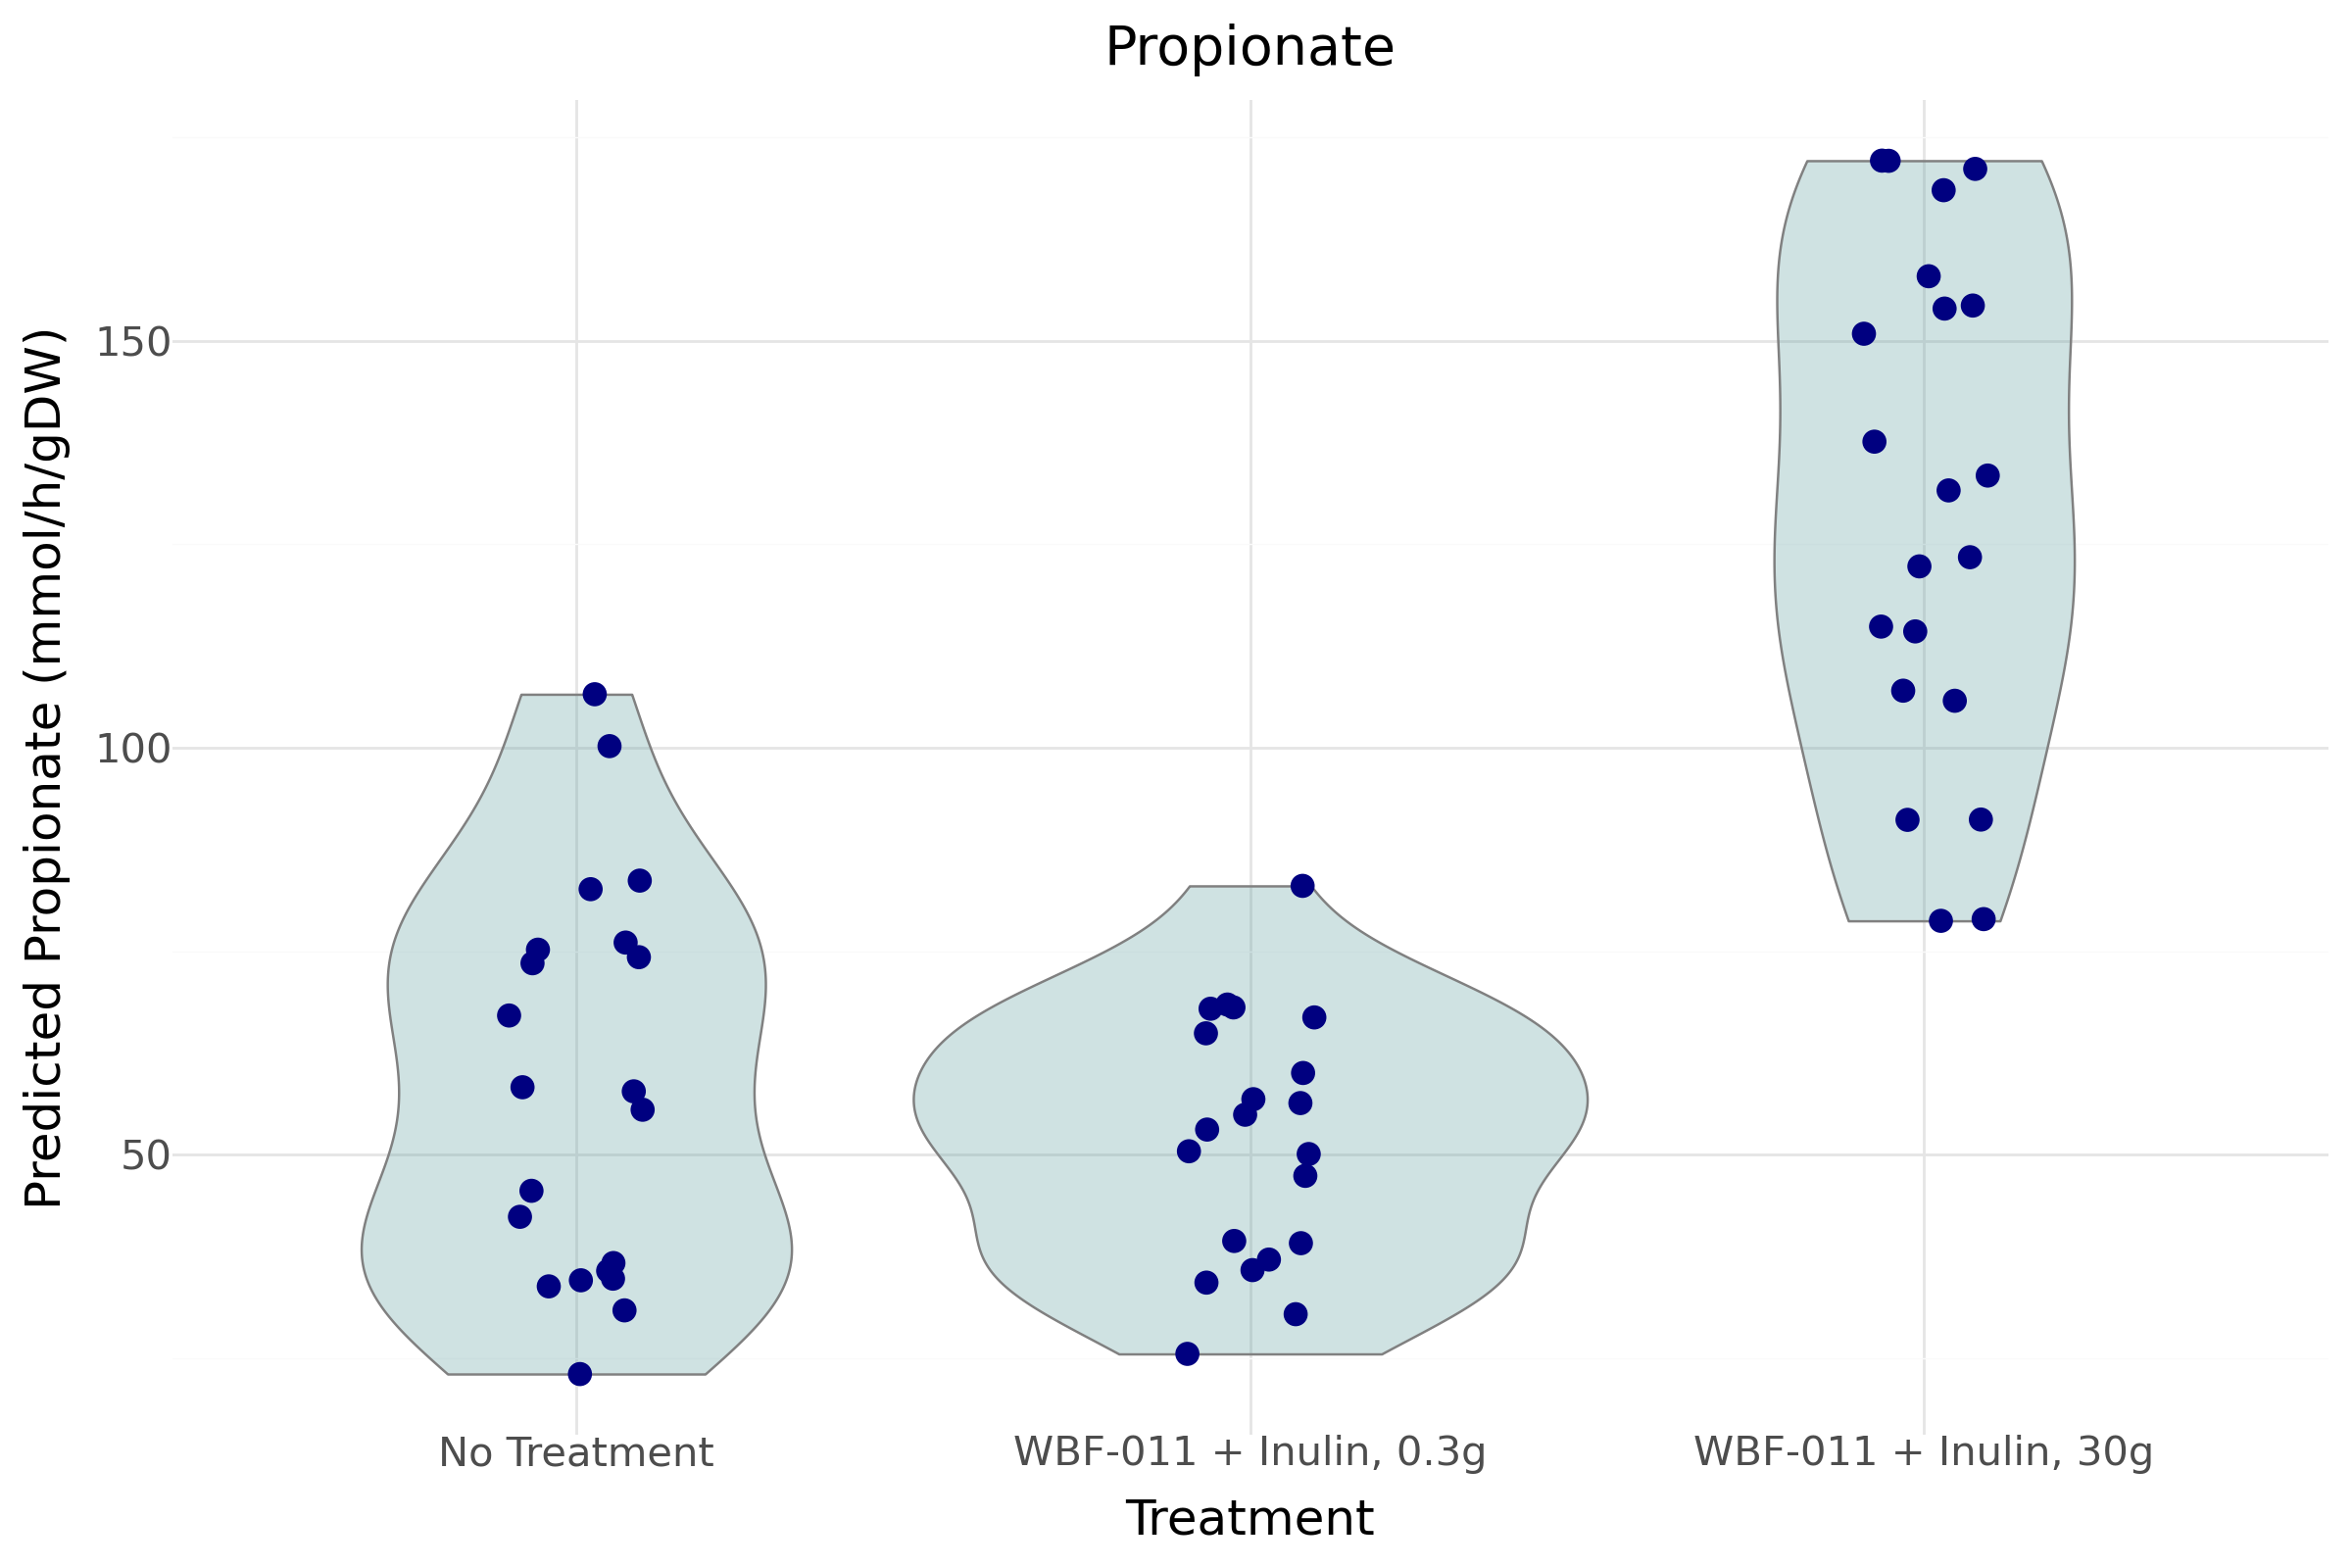

In [10]:
ppa_plot = (ggplot(production_ppa, aes(x = 'treatment', y = 'flux'))
            +geom_violin(color = 'gray', fill = 'cadetblue', alpha = 0.3, width = 1)
            +geom_jitter(color = 'navy', width = .1, size = 4)
            +labs(x = 'Treatment', y = 'Predicted Propionate (mmol/h/gDW)',  title = 'Propionate')
            +scale_x_discrete(limits = ['No Treatment','WBF-011 + Inulin, 0.3g','WBF-011 + Inulin, 30g'])
            # +ylim(0, 70)
            +theme_minimal()
            +theme(figure_size=(12, 8),  axis_title=element_text(size=18),
        axis_text=element_text(size=15),
                   
        plot_title=element_text(size=20))
            
           )
# ggsave(ppa_plot, '../figures/propionatePrediction.svg',dpi =200)
ppa_plot

## Test Significance
Use non-parametric Mann-Whitney to determine signficance in difference of propionate production between conditions

In [11]:
scipy.stats.mannwhitneyu(production_ppa[production_ppa['treatment'] == 'WBF-011 + Inulin, 0.3g']['flux'],
                         production_ppa[production_ppa['treatment'] == 'No Treatment']['flux'])

MannwhitneyuResult(statistic=np.float64(190.0), pvalue=np.float64(0.4504456875848739))

## Probiotic Growth Rates
Retrieve the predicted growth rates for probiotic species in the placebo and treatment groups

In [30]:
# Growth in placebo models
probiotic_rates = growth_placebo.growth_rates.reset_index()

# Concatenate with growth in treatment models
probiotic_rates = pd.concat([probiotic_rates, growth_probiotic.growth_rates.reset_index()])

# Pivot data 
probiotic_rates_pvt = pd.pivot_table(probiotic_rates, 
                                    index = 'sample_id', 
                                    columns = 'compartments',
                                    values = 'growth_rate').fillna(0.0)

# Isolate probiotics
probiotic_rates_pvt = probiotic_rates_pvt[['Akkermansia_muciniphila','Bifidobacterium_longum']]


# Reformate Sample IDs
probiotic_rates_pvt.index = probiotic_rates_pvt.index.str.split('_').str[1]

## Merge with Glucose AUC
Merge predicted growth rates with primary metabolic endpoint

In [31]:
# Read glucose AUC data
glucose = pyreadr.read_r('/proj/gibbons/2024_Pendulum_trial/tabGluCtl.RDS')[None].set_index('Subject')

# Omit WBF010 data
glucose = glucose.loc[glucose['treatment'] != 'wbf10']

# Concate with probiotic growth rates
combined_measures = pd.concat([glucose, probiotic_rates_pvt], axis = 1)

# Drop missing rows
combined_measures.dropna(subset = 'treatment', inplace = True)

combined_measures.head()

,treatment,A1C_Week12,A1C_Baseline,AUC_INC_GLU_Week12,AUC_INC_GLU_Baseline,AUC_TOT_GLU_Week12,AUC_TOT_GLU_Baseline,deltaA1c,deltaAucTot,deltaAucInc,Akkermansia_muciniphila,Bifidobacterium_longum
118,placebo,6.8,7.6,13560.0,5400.0,37140.0,34740.0,-0.8,13.333333,45.333333,0.000000,0.0
120,placebo,10.4,9.3,8700.0,9240.0,43080.0,40020.0,1.1,17.000000,-3.000000,0.000000,0.0
124,placebo,9.1,9.1,17085.0,21015.0,53625.0,55755.0,0.0,-11.833333,-21.833333,0.038725,0.0
130,placebo,6.0,7.4,11490.0,6420.0,31470.0,30900.0,-1.4,3.166667,28.166667,0.000000,0.0
42,placebo,10.4,9.1,9690.0,10170.0,62610.0,62730.0,1.3,-0.666667,-2.666667,NaN,NaN


## Find Associations 
Look for associations between growth of probitoic species, and metabolic endpoints

In [32]:
delta_y_vars = ['deltaA1c', 'deltaAucTot', 'deltaAucInc']
x_vars = ['Akkermansia_muciniphila', 'Bifidobacterium_longum']

results = []

for y in delta_y_vars:
    for x in x_vars:
        sub = combined_measures[[y, x]].dropna()
        X = sm.add_constant(sub[[x]])
        model = sm.OLS(sub[y], X).fit()
        results.append({
            'dependent': y,
            'independent': x,
            'coef_independent': model.params[x],
            'pval_independent': model.pvalues[x],
            'r2': model.rsquared,
            'model_type': 'delta~delta'
        })


results_df = pd.DataFrame(results)
results_df['p_corrected'] = fdrcorrection(results_df['pval_independent'])[1]


results_df

,dependent,independent,coef_independent,pval_independent,r2,model_type,p_corrected
0,deltaA1c,Akkermansia_muciniphila,0.891702,0.431890,0.019417,delta~delta,0.518268
1,deltaA1c,Bifidobacterium_longum,-0.916323,0.310780,0.032083,delta~delta,0.473726
2,deltaAucTot,Akkermansia_muciniphila,-20.893119,0.790017,0.002179,delta~delta,0.790017
3,deltaAucTot,Bifidobacterium_longum,-92.089783,0.138416,0.065309,delta~delta,0.415249
4,deltaAucInc,Akkermansia_muciniphila,-43.791405,0.315817,0.030481,delta~delta,0.473726
5,deltaAucInc,Bifidobacterium_longum,-55.417399,0.110653,0.075301,delta~delta,0.415249


## Plot Change in AUC Between Treatments

In [ ]:
glucoseAUC_plot = (ggplot(combined_measures, aes(x='treatment', y='deltaAucInc'))
      + geom_boxplot(alpha=0.7,outlier_alpha=0)
      +geom_jitter(width = 0.1,size = 3)
      + labs(title='Change in AUC',
             x='',
             y='ΔAUC (Incremental Glucose)',
             fill='Treatment')
      + scale_x_discrete(limits = ['placebo','wbf11'], labels = ['Placebo','WBF-011 + \n Inulin, 0.3g'])
      + theme_minimal()
      + theme(figure_size=(6.6, 7),
        axis_title=element_text(size=24),
        axis_text=element_text(size=20, color = 'black'),
        plot_title=element_text(size=24)
      )
)
# ggsave(glucoseAUC_plot, '../figures/auc_treatment_groups.svg',dpi = 200, bbox_inches='tight')
glucoseAUC_plot

## Plot change in A. muciniphila Growth Between Treatments 

In [ ]:
AMUC_plot = (ggplot(combined_measures, aes(x='treatment', y='Akkermansia_muciniphila'))
      + geom_boxplot(alpha=0.7,outlier_alpha=0)
      +geom_jitter(width = 0.1,size = 3)
      + labs(title='Predicted Akkermansia Growth',
             x='',
             y='Growth rate (mmol/h/gDW)',
             fill='Treatment')
      + scale_x_discrete(limits = ['placebo','wbf11'], labels = ['Placebo','WBF-011 + \n Inulin, 0.3g'])
      + theme_minimal()
      + theme(figure_size=(6.6, 7),
        axis_title=element_text(size=24),
        axis_text=element_text(size=20, color = 'black'),
        plot_title=element_text(size=24)
      )
)

# ggsave(AMUC_plot, '../figures/amuc_treatment_groups.svg',dpi = 200,bbox_inches='tight')
AMUC_plot

## Plot A. muciniphila Growth vs. ΔglucoseAUc

In [ ]:
butCRP_plot = (ggplot(df, aes(x = 'Akkermansia_muciniphila', y = 'deltaAucInc'))
            +geom_point(size = 3)
            +geom_smooth(method = 'lm')
            +labs(x = 'A. muciniphila Growth Rate (1/h)', y = 'Δ Glucose AUC', title = 'A. muciniphila Growth vs.\n         Δ Glucose AUC')
            +theme_minimal()    
            +theme(figure_size=(6.6, 7),  axis_title=element_text(size=24),
        axis_text=element_text(size=20),
        plot_title=element_text(size=24, ha = 'center'))
           )
ggsave(butCRP_plot, '../figures/amuc_gauc.svg', dpi = 300, bbox_inches='tight')
butCRP_plot